In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import os
import time
import datetime

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score,f1_score
from sklearn.metrics import cohen_kappa_score

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

#Global Parameters and Variables loaded 
import config

In [2]:
# load dataloader
if config.ADSMI:
    from DL_finetune import ADSMI_DL_TVsplit as DL
    data_name = 'ADSMI'

In [3]:
#empty cuda cache
torch.cuda.empty_cache()

config.desired_length_in_seconds = 7


## Models


In [4]:
print(config.channels)

class Resnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50_Classifier, self).__init__()
        self.resnet50 = models.resnet50()
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)
    



class ResNet101_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101_Classifier, self).__init__()
        self.resnet101 = models.resnet101()
        
        # Modify the first convolutional layer
        self.resnet101.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer
        self.resnet101.fc = nn.Identity()  # Set the final layer to an identity mapping
        
        # Define the custom fully connected layers
        num_features = 2048 
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.resnet101(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

    
class ModifiedResnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResnet50_Classifier, self).__init__()
        
        # Load the pretrained ResNet-50 model
        #self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50 = models.resnet50()
        # Modify the first convolutional layer
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer
        self.resnet50.fc = nn.Identity()  # Set the final layer to an identity mapping
        
        # Define the custom fully connected layers
        num_features = 2048 
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

3


## Train Test and Val split

In [5]:
from Slit_and_validation_fun import *

train_df, test_df, val_df = train_test_ADSMI()

foldername = "RS96_F1_scores"
# Load the dataframe
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)

Train size:  3776
Test size:  472
Val size:  472


In [6]:



print(train_df["Label_int"].value_counts())
print(test_df["Label_int"].value_counts())
print(val_df["Label_int"].value_counts())

train_loader, test_loader = DL.create_generators_finetune_train(train_df,test_df)




Label_int
0    1760
2    1332
1     570
3     114
Name: count, dtype: int64
Label_int
0    220
2    167
1     71
3     14
Name: count, dtype: int64
Label_int
0    220
2    166
1     72
3     14
Name: count, dtype: int64


## Model initialization

In [7]:

#  Create an instance of the model
num_classes = len(set(labels_file["Label_int"]))  
#model = Resnet50_Classifier(num_classes)
model = ModifiedResnet50_Classifier(num_classes)
#model = ResNet101_Classifier(num_classes)

# Hyperparameters
num_epochs = config.finetune_epochs 
learning_rate = 0.0003
weight_decay = 0  # L2 regularization
batch_size = config.batch_size
patience = config.patience

#  Transfer the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay ) # Adjust the value as needed)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.6, verbose=True)

#new folder path
standalone_results_path = f'./results_standalone/SA_ADSMI_{foldername}'#{datetime.datetime.now().strftime("%Y-%m-%d-%H")}'

# Create a directory to save the results
if not os.path.exists(standalone_results_path):
    os.makedirs(standalone_results_path)

with open(f'{standalone_results_path}/log_file.txt', 'w') as log_file:
    log_file.write(f'########################################################\n')
    log_file.write(f'training on {data_name} dataset\n')
    log_file.write(f'Learning rate: {learning_rate}\n')
    log_file.write(f'Weight decay: {weight_decay}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Number of epochs: {num_epochs}\n')
    log_file.write(f'Patience: {patience}\n')
    log_file.write(f'Number of classes: {num_classes}\n')
    log_file.write(f'Train size: {len(train_df)}\n')
    log_file.write(f'Test size: {len(test_df)}\n')
    log_file.write(f'Val size: {len(val_df)}\n')
    log_file.write(f'Length of train data in seconds: {config.desired_length_in_seconds}\n')
    log_file.write(f'freq_mask_param : {config.freq_mask_param}\n')
    log_file.write(f'time_mask_param : {config.time_mask_param}\n')
    log_file.write(f'########################################################\n\n')

train_losses = []
val_losses = []
macro_avg_f1_scores = []
best_accuracy = 0
best_f1_macro_avg = 0
best_loss = 1000
early_stop_counter = 0
#config.model_path = "./results_standalone/newgpu2_checkpoint.pth"


In [8]:

from sklearn.metrics import f1_score as calculate_f1_score

for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Temporary list for storing training losses for each batch
    all_predicted = []
    all_labels = []
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        epoch_train_losses.append(loss.item())  # Append current batch loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)  # Append average loss to main list

    model.eval()
    epoch_val_losses = []  # Temporary list for storing validation losses for each batch
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())  # Append current batch loss

            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate average validation loss for the epoch
    avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    val_losses.append(avg_val_loss)  # Append average loss to main list

    # Model saving and logging based on accuracy, loss, and now F1 score
    accuracy = correct_predictions / total_samples

    # Calculate macro avg f1 score using the alias
    f1_macro_avg = calculate_f1_score(all_labels, all_predicted, average='macro')
    macro_avg_f1_scores.append(f1_macro_avg)


    if f1_macro_avg > best_f1_macro_avg:
        best_f1_macro_avg = f1_macro_avg
        torch.save(model, standalone_results_path + '/checkpoint_best_f1.pth')
        early_stop_counter = 0
        with open(standalone_results_path + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best F1 Score improved on epoch {epoch}: {best_f1_macro_avg:.4f}\n")

    if correct_predictions / total_samples > best_accuracy:
        best_accuracy = accuracy
        torch.save(model, standalone_results_path + '/checkpoint.pth')
        early_stop_counter = 0
        with open(standalone_results_path + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best accuracy improved on epoch {epoch}: {best_accuracy * 100:.2f}%\n")
    
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model, standalone_results_path + '/checkpoint_best_loss.pth')
        early_stop_counter = 0
        with open(standalone_results_path + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best loss improved on epoch {epoch}: {best_loss:.4f}\n")

    scheduler.step(avg_val_loss)

    # Logging for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%", f"Val F1 Score: {f1_macro_avg:.4f}")
    with open(standalone_results_path + '/log_file.txt', 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy}, Early stopping count: {early_stop_counter} from {patience}\n")

    # Early stopping
    early_stop_counter += 1
    if early_stop_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break


100%|██████████| 236/236 [00:17<00:00, 13.56it/s]


Epoch [1/120], Train Loss: 0.9350, Val Loss: 0.7571, Val Accuracy: 70.97% Val F1 Score: 0.3924


100%|██████████| 236/236 [00:16<00:00, 14.65it/s]


Epoch [2/120], Train Loss: 0.7736, Val Loss: 0.8250, Val Accuracy: 58.26% Val F1 Score: 0.4413


100%|██████████| 236/236 [00:15<00:00, 14.77it/s]


Epoch [3/120], Train Loss: 0.7019, Val Loss: 0.5915, Val Accuracy: 74.58% Val F1 Score: 0.6006


100%|██████████| 236/236 [00:16<00:00, 14.72it/s]


Epoch [4/120], Train Loss: 0.6584, Val Loss: 0.7365, Val Accuracy: 66.74% Val F1 Score: 0.5739


100%|██████████| 236/236 [00:15<00:00, 14.79it/s]


Epoch [5/120], Train Loss: 0.6595, Val Loss: 0.5083, Val Accuracy: 83.47% Val F1 Score: 0.7121


100%|██████████| 236/236 [00:15<00:00, 14.88it/s]


Epoch [6/120], Train Loss: 0.6325, Val Loss: 0.4246, Val Accuracy: 84.53% Val F1 Score: 0.7707


100%|██████████| 236/236 [00:15<00:00, 14.80it/s]


Epoch [7/120], Train Loss: 0.6244, Val Loss: 0.3873, Val Accuracy: 86.44% Val F1 Score: 0.7779


100%|██████████| 236/236 [00:16<00:00, 14.68it/s]


Epoch [8/120], Train Loss: 0.5911, Val Loss: 0.4465, Val Accuracy: 83.90% Val F1 Score: 0.7964


100%|██████████| 236/236 [00:15<00:00, 14.95it/s]


Epoch [9/120], Train Loss: 0.5642, Val Loss: 0.3956, Val Accuracy: 84.75% Val F1 Score: 0.7500


100%|██████████| 236/236 [00:15<00:00, 14.86it/s]


Epoch [10/120], Train Loss: 0.5788, Val Loss: 0.4622, Val Accuracy: 82.84% Val F1 Score: 0.7831


100%|██████████| 236/236 [00:15<00:00, 14.98it/s]


Epoch [11/120], Train Loss: 0.5520, Val Loss: 0.5121, Val Accuracy: 80.93% Val F1 Score: 0.7389


100%|██████████| 236/236 [00:15<00:00, 14.98it/s]


Epoch [12/120], Train Loss: 0.5460, Val Loss: 0.4302, Val Accuracy: 86.02% Val F1 Score: 0.7627


100%|██████████| 236/236 [00:15<00:00, 14.97it/s]


Epoch [13/120], Train Loss: 0.5562, Val Loss: 0.4270, Val Accuracy: 84.96% Val F1 Score: 0.7667


100%|██████████| 236/236 [00:15<00:00, 14.79it/s]


Epoch [14/120], Train Loss: 0.5432, Val Loss: 0.3753, Val Accuracy: 86.23% Val F1 Score: 0.8082


100%|██████████| 236/236 [00:15<00:00, 14.80it/s]


Epoch [15/120], Train Loss: 0.5359, Val Loss: 0.4238, Val Accuracy: 85.81% Val F1 Score: 0.7349


100%|██████████| 236/236 [00:15<00:00, 14.81it/s]


Epoch [16/120], Train Loss: 0.5212, Val Loss: 0.4352, Val Accuracy: 85.38% Val F1 Score: 0.7947


100%|██████████| 236/236 [00:21<00:00, 10.98it/s]


Epoch [17/120], Train Loss: 0.5331, Val Loss: 0.3706, Val Accuracy: 86.44% Val F1 Score: 0.7796


100%|██████████| 236/236 [00:22<00:00, 10.43it/s]


Epoch [18/120], Train Loss: 0.5274, Val Loss: 0.3939, Val Accuracy: 86.65% Val F1 Score: 0.8123


100%|██████████| 236/236 [00:15<00:00, 14.84it/s]


Epoch [19/120], Train Loss: 0.5089, Val Loss: 0.3339, Val Accuracy: 88.56% Val F1 Score: 0.8210


100%|██████████| 236/236 [00:16<00:00, 14.68it/s]


Epoch [20/120], Train Loss: 0.5252, Val Loss: 0.3318, Val Accuracy: 89.62% Val F1 Score: 0.8413


100%|██████████| 236/236 [00:16<00:00, 14.65it/s]


Epoch [21/120], Train Loss: 0.5026, Val Loss: 0.3338, Val Accuracy: 88.14% Val F1 Score: 0.8118


100%|██████████| 236/236 [00:16<00:00, 14.72it/s]


Epoch [22/120], Train Loss: 0.4983, Val Loss: 0.3169, Val Accuracy: 90.04% Val F1 Score: 0.8543


100%|██████████| 236/236 [00:15<00:00, 14.87it/s]


Epoch [23/120], Train Loss: 0.4905, Val Loss: 0.3067, Val Accuracy: 90.89% Val F1 Score: 0.8829


100%|██████████| 236/236 [00:15<00:00, 14.90it/s]


Epoch [24/120], Train Loss: 0.4967, Val Loss: 0.3573, Val Accuracy: 86.23% Val F1 Score: 0.8019


100%|██████████| 236/236 [00:15<00:00, 14.94it/s]


Epoch [25/120], Train Loss: 0.5123, Val Loss: 0.3842, Val Accuracy: 87.08% Val F1 Score: 0.8091


100%|██████████| 236/236 [00:15<00:00, 14.94it/s]


Epoch [26/120], Train Loss: 0.5046, Val Loss: 0.3335, Val Accuracy: 87.71% Val F1 Score: 0.8149


100%|██████████| 236/236 [00:15<00:00, 14.95it/s]


Epoch [27/120], Train Loss: 0.4940, Val Loss: 0.3195, Val Accuracy: 88.35% Val F1 Score: 0.8434


100%|██████████| 236/236 [00:15<00:00, 14.88it/s]


Epoch [28/120], Train Loss: 0.4893, Val Loss: 0.3079, Val Accuracy: 88.77% Val F1 Score: 0.8131


100%|██████████| 236/236 [00:15<00:00, 14.95it/s]


Epoch [29/120], Train Loss: 0.4588, Val Loss: 0.3287, Val Accuracy: 87.71% Val F1 Score: 0.8566


100%|██████████| 236/236 [00:15<00:00, 15.05it/s]


Epoch 00030: reducing learning rate of group 0 to 1.8000e-04.
Epoch [30/120], Train Loss: 0.4883, Val Loss: 0.3364, Val Accuracy: 89.41% Val F1 Score: 0.8531


100%|██████████| 236/236 [00:15<00:00, 15.03it/s]


Epoch [31/120], Train Loss: 0.4541, Val Loss: 0.3083, Val Accuracy: 88.77% Val F1 Score: 0.8457


100%|██████████| 236/236 [00:15<00:00, 14.90it/s]


Epoch [32/120], Train Loss: 0.4560, Val Loss: 0.2992, Val Accuracy: 90.47% Val F1 Score: 0.8553


100%|██████████| 236/236 [00:16<00:00, 14.66it/s]


Epoch [33/120], Train Loss: 0.4599, Val Loss: 0.3017, Val Accuracy: 88.77% Val F1 Score: 0.8516


100%|██████████| 236/236 [00:16<00:00, 14.55it/s]


Epoch [34/120], Train Loss: 0.4341, Val Loss: 0.2695, Val Accuracy: 90.89% Val F1 Score: 0.8634


100%|██████████| 236/236 [00:16<00:00, 14.75it/s]


Epoch [35/120], Train Loss: 0.4385, Val Loss: 0.3098, Val Accuracy: 88.77% Val F1 Score: 0.8370


100%|██████████| 236/236 [00:15<00:00, 14.82it/s]


Epoch [36/120], Train Loss: 0.4355, Val Loss: 0.3064, Val Accuracy: 91.10% Val F1 Score: 0.8655


100%|██████████| 236/236 [00:15<00:00, 14.80it/s]


Epoch [37/120], Train Loss: 0.4308, Val Loss: 0.2512, Val Accuracy: 91.10% Val F1 Score: 0.8729


100%|██████████| 236/236 [00:15<00:00, 14.80it/s]


Epoch [38/120], Train Loss: 0.4467, Val Loss: 0.3052, Val Accuracy: 88.35% Val F1 Score: 0.8508


100%|██████████| 236/236 [00:16<00:00, 14.73it/s]


Epoch [39/120], Train Loss: 0.4088, Val Loss: 0.3092, Val Accuracy: 87.50% Val F1 Score: 0.8374


100%|██████████| 236/236 [00:16<00:00, 14.73it/s]


Epoch [40/120], Train Loss: 0.4276, Val Loss: 0.3466, Val Accuracy: 87.08% Val F1 Score: 0.8321


100%|██████████| 236/236 [00:15<00:00, 14.90it/s]


Epoch [41/120], Train Loss: 0.4262, Val Loss: 0.3616, Val Accuracy: 86.23% Val F1 Score: 0.8159


100%|██████████| 236/236 [00:15<00:00, 14.95it/s]


Epoch [42/120], Train Loss: 0.4330, Val Loss: 0.2910, Val Accuracy: 90.04% Val F1 Score: 0.8670


100%|██████████| 236/236 [00:15<00:00, 14.96it/s]


Epoch [43/120], Train Loss: 0.4084, Val Loss: 0.2896, Val Accuracy: 89.41% Val F1 Score: 0.8618


100%|██████████| 236/236 [00:15<00:00, 14.92it/s]


Epoch 00044: reducing learning rate of group 0 to 1.0800e-04.
Epoch [44/120], Train Loss: 0.4081, Val Loss: 0.2951, Val Accuracy: 90.89% Val F1 Score: 0.8509


100%|██████████| 236/236 [00:15<00:00, 14.94it/s]


Epoch [45/120], Train Loss: 0.3918, Val Loss: 0.2775, Val Accuracy: 90.47% Val F1 Score: 0.8766


100%|██████████| 236/236 [00:15<00:00, 14.94it/s]


Epoch [46/120], Train Loss: 0.3996, Val Loss: 0.2815, Val Accuracy: 91.53% Val F1 Score: 0.8870


100%|██████████| 236/236 [00:15<00:00, 14.95it/s]


Epoch [47/120], Train Loss: 0.3986, Val Loss: 0.2587, Val Accuracy: 91.31% Val F1 Score: 0.8844


100%|██████████| 236/236 [00:15<00:00, 15.02it/s]


Epoch [48/120], Train Loss: 0.4012, Val Loss: 0.2539, Val Accuracy: 93.43% Val F1 Score: 0.9064


100%|██████████| 236/236 [00:15<00:00, 14.99it/s]


Epoch [49/120], Train Loss: 0.3943, Val Loss: 0.2827, Val Accuracy: 90.25% Val F1 Score: 0.8774


100%|██████████| 236/236 [00:15<00:00, 14.77it/s]


Epoch [50/120], Train Loss: 0.3769, Val Loss: 0.2827, Val Accuracy: 90.25% Val F1 Score: 0.8767


100%|██████████| 236/236 [00:15<00:00, 14.84it/s]


Epoch 00051: reducing learning rate of group 0 to 6.4800e-05.
Epoch [51/120], Train Loss: 0.4051, Val Loss: 0.2903, Val Accuracy: 90.04% Val F1 Score: 0.8655


100%|██████████| 236/236 [00:16<00:00, 14.56it/s]


Epoch [52/120], Train Loss: 0.3793, Val Loss: 0.2961, Val Accuracy: 88.98% Val F1 Score: 0.8538


100%|██████████| 236/236 [00:16<00:00, 14.71it/s]


Epoch [53/120], Train Loss: 0.3671, Val Loss: 0.2861, Val Accuracy: 88.98% Val F1 Score: 0.8693


100%|██████████| 236/236 [00:15<00:00, 14.88it/s]


Epoch [54/120], Train Loss: 0.3859, Val Loss: 0.2880, Val Accuracy: 88.35% Val F1 Score: 0.8656


100%|██████████| 236/236 [00:15<00:00, 14.91it/s]


Epoch [55/120], Train Loss: 0.3634, Val Loss: 0.2557, Val Accuracy: 91.31% Val F1 Score: 0.8830


100%|██████████| 236/236 [00:15<00:00, 14.87it/s]


Epoch [56/120], Train Loss: 0.3583, Val Loss: 0.2683, Val Accuracy: 89.41% Val F1 Score: 0.8702


100%|██████████| 236/236 [00:15<00:00, 14.80it/s]


Epoch [57/120], Train Loss: 0.3467, Val Loss: 0.2567, Val Accuracy: 91.10% Val F1 Score: 0.8848


100%|██████████| 236/236 [00:15<00:00, 14.89it/s]


Epoch 00058: reducing learning rate of group 0 to 3.8880e-05.
Epoch [58/120], Train Loss: 0.3517, Val Loss: 0.2646, Val Accuracy: 90.68% Val F1 Score: 0.8892


100%|██████████| 236/236 [00:15<00:00, 14.77it/s]


Epoch [59/120], Train Loss: 0.3341, Val Loss: 0.2532, Val Accuracy: 91.31% Val F1 Score: 0.8877


100%|██████████| 236/236 [00:15<00:00, 14.96it/s]


Epoch [60/120], Train Loss: 0.3431, Val Loss: 0.2852, Val Accuracy: 88.98% Val F1 Score: 0.8680


100%|██████████| 236/236 [00:15<00:00, 14.95it/s]


Epoch [61/120], Train Loss: 0.3374, Val Loss: 0.2815, Val Accuracy: 89.41% Val F1 Score: 0.8753


100%|██████████| 236/236 [00:15<00:00, 14.99it/s]


Epoch [62/120], Train Loss: 0.3471, Val Loss: 0.2519, Val Accuracy: 90.89% Val F1 Score: 0.8838
Early stopping on epoch 62


## Losses Plot

Tend way more to overfitting than the pretraineds Models also with regularization with masking 

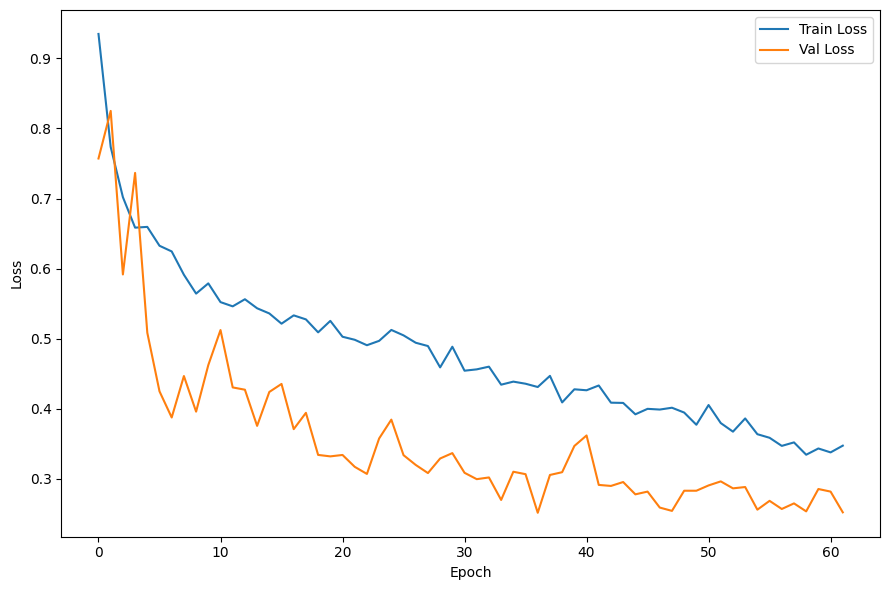

In [9]:
# Save full model
torch.save(model, standalone_results_path + '/Full_model_checkpoint.pth')

# Convert tensors in the lists to numbers if necessary
train_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

# Now plot these lists
plt.figure(figsize=(9, 6))
plt.plot(train_losses_cpu, label='Train Loss')
plt.plot(val_losses_cpu, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()


plt.savefig(f'{standalone_results_path}/loss_plot.png')

plt.show()

In [10]:
#standalone_results_path = "./results_standalone/SA_ADSMI_RS96_15sec_batch32_7_50_masking_ref3"


Evaluation Results:
Balanced Accuracy2: 85.20%
Test Accuracy: 91.53%

Evaluation Results:
Accuracy: 91.53%
Precision: 94.46%
Recall: 85.20%
F1-score: 89.03%
Kappa: 86.32%
                         precision    recall  f1-score   support

            [Kreischen]     0.8765    0.9682    0.9201       220
[Kreischen][Quietschen]     0.9444    0.7083    0.8095        72
              [Negativ]     0.9573    0.9458    0.9515       166
           [Quietschen]     1.0000    0.7857    0.8800        14

               accuracy                         0.9153       472
              macro avg     0.9446    0.8520    0.8903       472
           weighted avg     0.9190    0.9153    0.9131       472



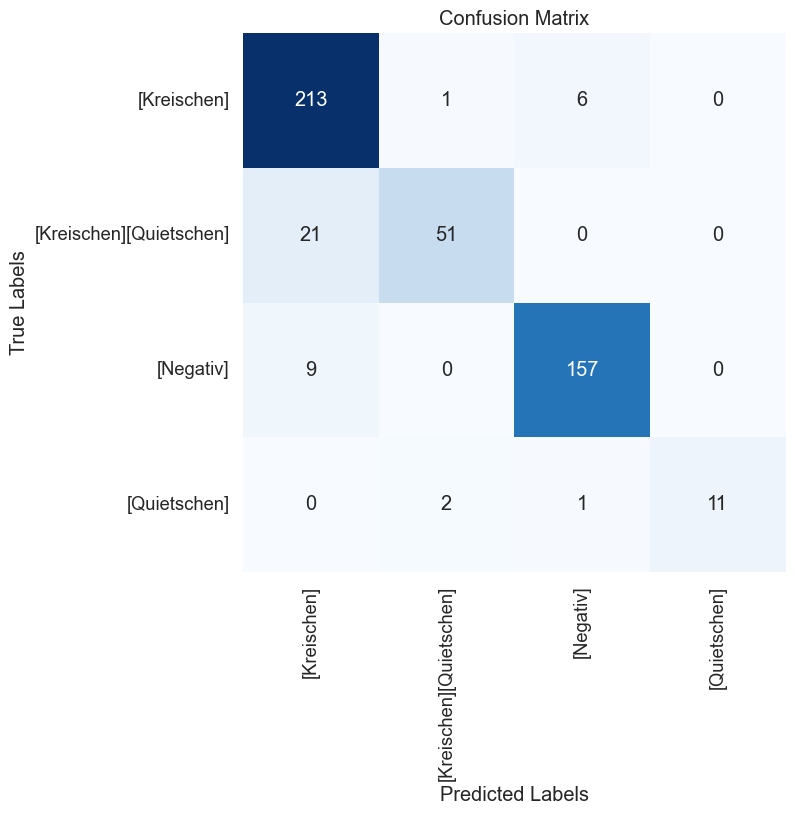

In [11]:
validation_fun(standalone_results_path,'/Full_model_checkpoint.pth',"full_model",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)


In [12]:
standalone_results_path

'./results_standalone/SA_ADSMI_RS96_F1_scores'


Evaluation Results:
Balanced Accuracy2: 83.05%
Test Accuracy: 90.47%

Evaluation Results:
Accuracy: 90.47%
Precision: 93.35%
Recall: 83.05%
F1-score: 87.25%
Kappa: 84.62%
                         precision    recall  f1-score   support

            [Kreischen]     0.8653    0.9636    0.9118       220
[Kreischen][Quietschen]     0.9123    0.7222    0.8062        72
              [Negativ]     0.9563    0.9217    0.9387       166
           [Quietschen]     1.0000    0.7143    0.8333        14

               accuracy                         0.9047       472
              macro avg     0.9335    0.8305    0.8725       472
           weighted avg     0.9085    0.9047    0.9028       472



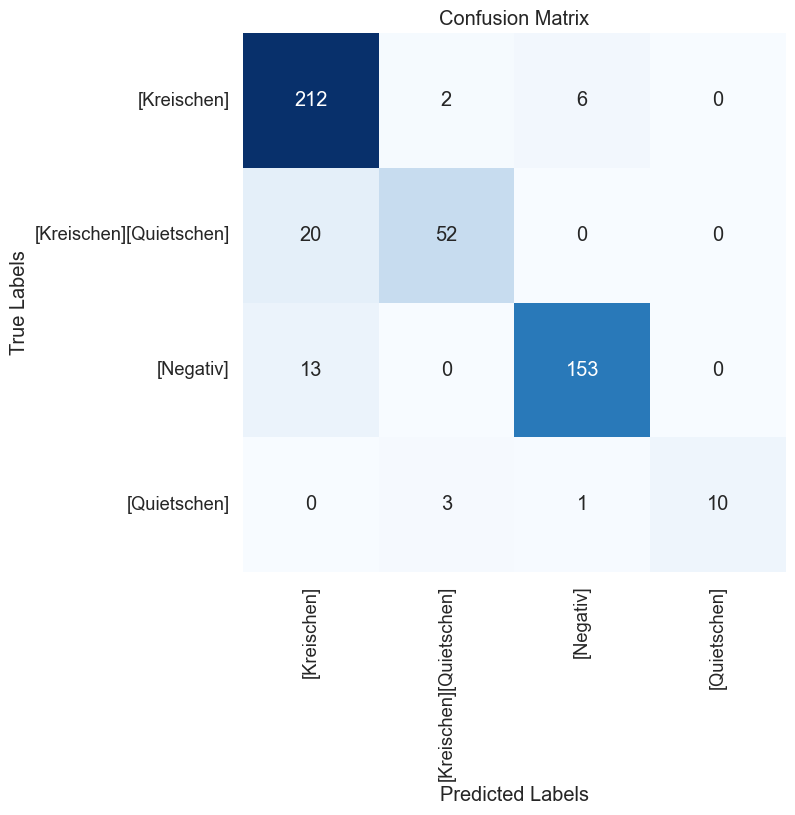

In [13]:
validation_fun(standalone_results_path,'/checkpoint_best_f1.pth',"f1_model",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)



Evaluation Results:
Balanced Accuracy2: 83.92%
Test Accuracy: 91.53%

Evaluation Results:
Accuracy: 91.53%
Precision: 94.24%
Recall: 83.92%
F1-score: 88.14%
Kappa: 86.33%
                         precision    recall  f1-score   support

            [Kreischen]     0.8770    0.9727    0.9224       220
[Kreischen][Quietschen]     0.9298    0.7361    0.8217        72
              [Negativ]     0.9627    0.9337    0.9480       166
           [Quietschen]     1.0000    0.7143    0.8333        14

               accuracy                         0.9153       472
              macro avg     0.9424    0.8392    0.8814       472
           weighted avg     0.9189    0.9153    0.9134       472



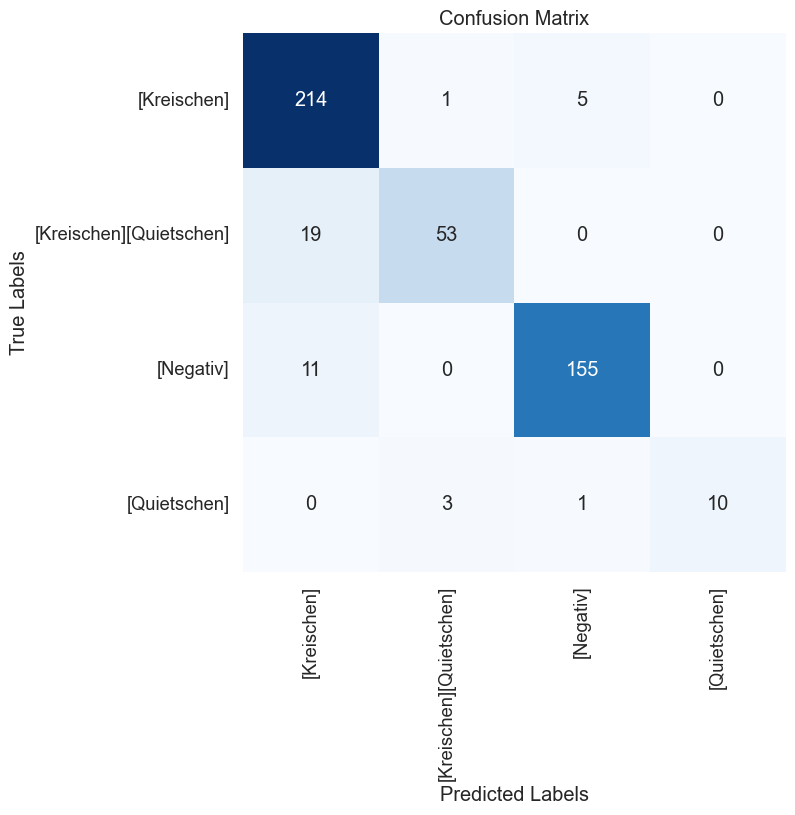

In [14]:
validation_fun(standalone_results_path,'/checkpoint.pth',"best_accuracy",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)


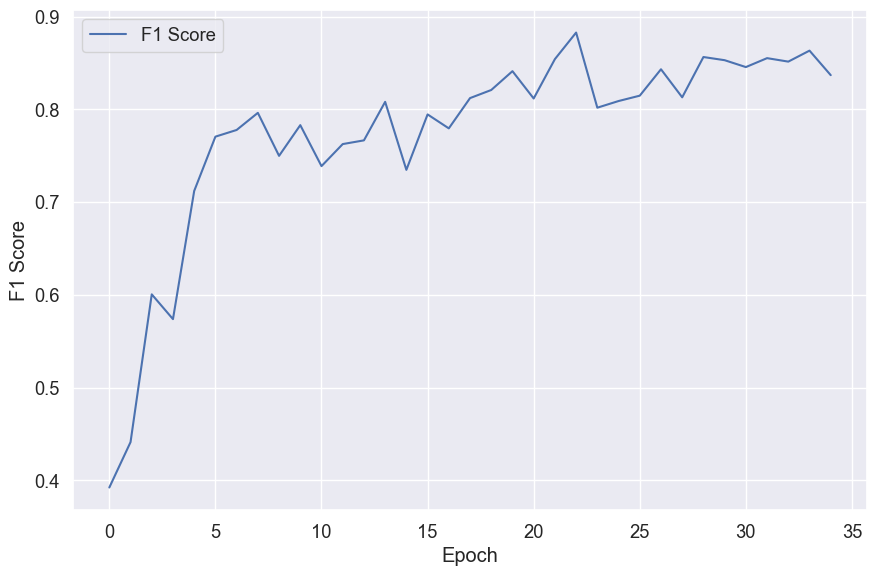

In [23]:
#plot f1 scores
plt.figure(figsize=(9, 6))
plt.plot(macro_avg_f1_scores[0:35], label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()

#pickle macro_avg_f1_scores
import pickle
with open(f'{standalone_results_path}/macro_avg_f1_scores.pkl', 'wb') as f:
    pickle.dump(macro_avg_f1_scores, f)




Evaluation Results:
Balanced Accuracy2: 84.01%
Test Accuracy: 90.89%

Evaluation Results:
Accuracy: 90.89%
Precision: 92.41%
Recall: 84.01%
F1-score: 87.36%
Kappa: 85.23%
                         precision    recall  f1-score   support

            [Kreischen]     0.8577    0.9864    0.9175       220
[Kreischen][Quietschen]     0.9412    0.6667    0.7805        72
              [Negativ]     0.9808    0.9217    0.9503       166
           [Quietschen]     0.9167    0.7857    0.8462        14

               accuracy                         0.9089       472
              macro avg     0.9241    0.8401    0.8736       472
           weighted avg     0.9155    0.9089    0.9060       472



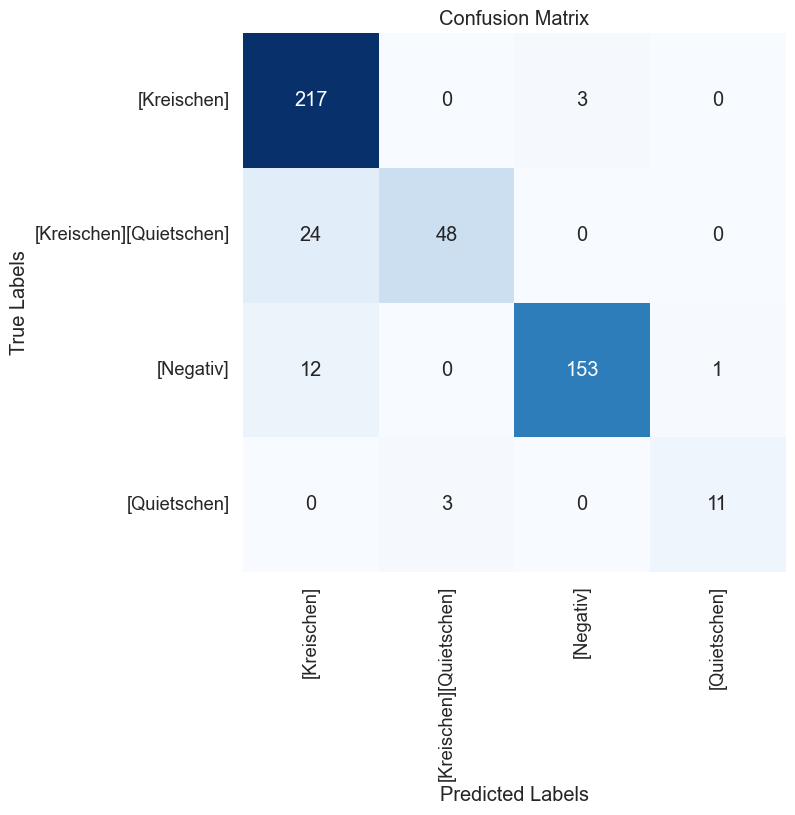

In [16]:
validation_fun(standalone_results_path,'/checkpoint_best_loss.pth',"best_loss",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)

In [17]:


# # and loaded any pre-trained weights, e.g., model = Resnet50_Classifier(num_classes)

# # Set the device for testing
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# config.val_sound_length = 20
# # Create a data loader for the test set
# val_loader = DL.create_generators_finetune_val(val_df)  

# #model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
# model = torch.load(standalone_results_path + '/Full_model_checkpoint.pth')
# # Transfer the model to the testing device
# model.to(device)

# # Define a criterion for evaluation (e.g., cross-entropy loss for classification)
# criterion = nn.CrossEntropyLoss()

# # Initialize variables for evaluation metrics (e.g., accuracy)
# correct_predictions = 0
# total_samples = 0

# # Define the label dictionary
# true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# # Set the model to evaluation mode 
# model.eval()

# # Initialize lists to store all true labels and predicted labels
# all_true_labels = []
# all_predicted_labels = []

# # Iterate through the test set
# with torch.no_grad():
#     for spectrograms, labels in val_loader:
#         # Move data to the testing device
#         spectrograms = spectrograms.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(spectrograms)
        
#         # Compute the predicted labels
#         _, predicted = torch.max(outputs, 1)

#         # Append true and predicted labels to the lists
#         all_true_labels.extend(labels.cpu().numpy())
#         all_predicted_labels.extend(predicted.cpu().numpy())

# # Convert lists to numpy arrays
# all_true_labels = np.array(all_true_labels)
# all_predicted_labels = np.array(all_predicted_labels)

# # Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
# accuracy = np.mean(all_true_labels == all_predicted_labels)
# precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


# #calculate balanced accuracy
# balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
# #kappa score
# cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


# print(f"\nEvaluation Results:")
# #print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
# print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

# print(f"Test Accuracy: {accuracy * 100:.2f}%")
# print(f"\nEvaluation Results:")
# print(f"Accuracy: {accuracy * 100:.2f}%")
# print(f"Precision: {precision * 100:.2f}%")
# print(f"Recall: {recall * 100:.2f}%")
# print(f"F1-score: {f1_score * 100:.2f}%")
# print(f"Kappa: {cohens_kappa * 100:.2f}%")

# conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
# def plot_confusion_matrix(conf_mat, class_labels):
#     plt.figure(figsize=(8, 6))
#     sns.set(font_scale=1.2)
    
#     class_labels = [str(label) for label in class_labels]
    
#     ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
#                 xticklabels=class_labels,
#                 yticklabels=class_labels)
    
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.xticks(rotation=90)

#     return plt.gcf()  # Return the current figure

# import config
# #create classification results text file
# with open(f'{standalone_results_path}/results_file_full.txt', 'w') as log_file:
#     log_file.write(f"########################################################\n")
#     log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
#     log_file.write(f"Time Mask: {config.time_mask_param}\n")
#     log_file.write(f"Spectro:\n")
#     log_file.write(f"        n_fft={2048},\n")
#     log_file.write(f"        hop_length = {512},\n")
#     log_file.write(f"        n_mels={128},  \n")
#     log_file.write(f"        win_length = {2048},\n")
#     log_file.write(f"Epochs: {num_epochs}\n")
#     log_file.write(f"Batch size: {batch_size}\n")
#     log_file.write(f"Optimizer: Adam\n")
#     log_file.write(f"Learning rate: {learning_rate}\n")
#     log_file.write(f"Weight decay: {weight_decay}\n")
#     log_file.write(f"Scheduler: ReduceLROnPlateau\n")
#     log_file.write(f"Model: ModifiedResnet50_Classifier \n")
#     log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
#     log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
#     log_file.write(f"\nEvaluation Results:\n")
#     log_file.write(f"Precision: {precision * 100:.2f}%\n")
#     log_file.write(f"Recall: {recall * 100:.2f}%\n")
#     log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
#     log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Confusion Matrix:\n")
#     log_file.write(f"{conf_mat}\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

# print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

# #save this plot as a png file
# plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
# plot.savefig(f'{standalone_results_path}/confusion_matrix_full.png')









In [18]:

# # Create a data loader for the test set
# val_loader = DL.create_generators_finetune_val(val_df)  

# #model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
# model = torch.load(standalone_results_path + '/checkpoint.pth')
# # Transfer the model to the testing device
# model.to(device)

# # Define a criterion for evaluation (e.g., cross-entropy loss for classification)
# criterion = nn.CrossEntropyLoss()

# # Initialize variables for evaluation metrics (e.g., accuracy)
# correct_predictions = 0
# total_samples = 0

# # Define the label dictionary
# true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# # Set the model to evaluation mode 
# model.eval()

# # Initialize lists to store all true labels and predicted labels
# all_true_labels = []
# all_predicted_labels = []

# # Iterate through the test set
# with torch.no_grad():
#     for spectrograms, labels in val_loader:
#         # Move data to the testing device
#         spectrograms = spectrograms.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(spectrograms)
        
#         # Compute the predicted labels
#         _, predicted = torch.max(outputs, 1)

#         # Append true and predicted labels to the lists
#         all_true_labels.extend(labels.cpu().numpy())
#         all_predicted_labels.extend(predicted.cpu().numpy())

# # Convert lists to numpy arrays
# all_true_labels = np.array(all_true_labels)
# all_predicted_labels = np.array(all_predicted_labels)

# # Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
# #use sklearn  accuracy 
# accuracy = np.mean(all_true_labels == all_predicted_labels)
# precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


# #calculate balanced accuracy
# balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
# #kappa score
# cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


# print(f"\nEvaluation Results:")
# #print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
# print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

# print(f"Test Accuracy: {accuracy * 100:.2f}%")
# print(f"\nEvaluation Results:")
# print(f"Accuracy: {accuracy * 100:.2f}%")
# print(f"Precision: {precision * 100:.2f}%")
# print(f"Recall: {recall * 100:.2f}%")
# print(f"F1-score: {f1_score * 100:.2f}%")
# print(f"Kappa: {cohens_kappa * 100:.2f}%")

# conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
# def plot_confusion_matrix(conf_mat, class_labels):
#     plt.figure(figsize=(8, 6))
#     sns.set(font_scale=1.2)
    
#     class_labels = [str(label) for label in class_labels]
    
#     ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
#                 xticklabels=class_labels,
#                 yticklabels=class_labels)
    
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.xticks(rotation=90)

#     return plt.gcf()  # Return the current figure

# import config
# #create classification results text file
# with open(f'{standalone_results_path}/results_file_best.txt', 'w') as log_file:
#     log_file.write(f"########################################################\n")
#     log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
#     log_file.write(f"Time Mask: {config.time_mask_param}\n")
#     log_file.write(f"Spectro:\n")
#     log_file.write(f"        n_fft={2048},\n")
#     log_file.write(f"        hop_length = {512},\n")
#     log_file.write(f"        n_mels={128},  \n")
#     log_file.write(f"        win_length = {2048},\n")
#     log_file.write(f"Epochs: {num_epochs}\n")
#     log_file.write(f"Batch size: {batch_size}\n")
#     log_file.write(f"Optimizer: Adam\n")
#     log_file.write(f"Learning rate: {learning_rate}\n")
#     log_file.write(f"Weight decay: {weight_decay}\n")
#     log_file.write(f"Scheduler: ReduceLROnPlateau\n")
#     log_file.write(f"Model: ModifiedResnet50_Classifier \n")
#     log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
#     log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
#     log_file.write(f"\nEvaluation Results:\n")
#     log_file.write(f"Precision: {precision * 100:.2f}%\n")
#     log_file.write(f"Recall: {recall * 100:.2f}%\n")
#     log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
#     log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Confusion Matrix:\n")
#     log_file.write(f"{conf_mat}\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

# print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

# #save this plotas a png file
# plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
# plot.savefig(f'{standalone_results_path}/confusion_matrix_best.png')









In [19]:

# # Create a data loader for the test set
# val_loader = DL.create_generators_finetune_val(val_df)  

# #model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
# model = torch.load(standalone_results_path + '/checkpoint_best_loss.pth')
# # Transfer the model to the testing device
# model.to(device)

# # Define a criterion for evaluation (e.g., cross-entropy loss for classification)
# criterion = nn.CrossEntropyLoss()

# # Initialize variables for evaluation metrics (e.g., accuracy)
# correct_predictions = 0
# total_samples = 0

# # Define the label dictionary
# true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# # Set the model to evaluation mode 
# model.eval()

# # Initialize lists to store all true labels and predicted labels
# all_true_labels = []
# all_predicted_labels = []

# # Iterate through the test set
# with torch.no_grad():
#     for spectrograms, labels in val_loader:
#         # Move data to the testing device
#         spectrograms = spectrograms.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(spectrograms)
        
#         # Compute the predicted labels
#         _, predicted = torch.max(outputs, 1)

#         # Append true and predicted labels to the lists
#         all_true_labels.extend(labels.cpu().numpy())
#         all_predicted_labels.extend(predicted.cpu().numpy())

# # Convert lists to numpy arrays
# all_true_labels = np.array(all_true_labels)
# all_predicted_labels = np.array(all_predicted_labels)

# # Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
# #use sklearn  accuracy 
# accuracy = np.mean(all_true_labels == all_predicted_labels)
# precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


# #calculate balanced accuracy
# balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
# #kappa score
# cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


# print(f"\nEvaluation Results:")
# #print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
# print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

# print(f"Test Accuracy: {accuracy * 100:.2f}%")
# print(f"\nEvaluation Results:")
# print(f"Accuracy: {accuracy * 100:.2f}%")
# print(f"Precision: {precision * 100:.2f}%")
# print(f"Recall: {recall * 100:.2f}%")
# print(f"F1-score: {f1_score * 100:.2f}%")
# print(f"Kappa: {cohens_kappa * 100:.2f}%")

# conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
# def plot_confusion_matrix(conf_mat, class_labels):
#     plt.figure(figsize=(8, 6))
#     sns.set(font_scale=1.2)
    
#     class_labels = [str(label) for label in class_labels]
    
#     ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
#                 xticklabels=class_labels,
#                 yticklabels=class_labels)
    
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.xticks(rotation=90)

#     return plt.gcf()  # Return the current figure

# import config
# #create classification results text file
# with open(f'{standalone_results_path}/results_file_best_loss.txt', 'w') as log_file:
#     log_file.write(f"########################################################\n")
#     log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
#     log_file.write(f"Time Mask: {config.time_mask_param}\n")
#     log_file.write(f"Spectro:\n")
#     log_file.write(f"        n_fft={2048},\n")
#     log_file.write(f"        hop_length = {512},\n")
#     log_file.write(f"        n_mels={128},  \n")
#     log_file.write(f"        win_length = {2048},\n")
#     log_file.write(f"Epochs: {num_epochs}\n")
#     log_file.write(f"Batch size: {batch_size}\n")
#     log_file.write(f"Optimizer: Adam\n")
#     log_file.write(f"Learning rate: {learning_rate}\n")
#     log_file.write(f"Weight decay: {weight_decay}\n")
#     log_file.write(f"Scheduler: ReduceLROnPlateau\n")
#     log_file.write(f"Model: ModifiedResnet50_Classifier \n")
#     log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
#     log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
#     log_file.write(f"\nEvaluation Results:\n")
#     log_file.write(f"Precision: {precision * 100:.2f}%\n")
#     log_file.write(f"Recall: {recall * 100:.2f}%\n")
#     log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
#     log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Confusion Matrix:\n")
#     log_file.write(f"{conf_mat}\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

# print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

# #save this plotas a png file
# plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
# plot.savefig(f'{standalone_results_path}/confusion_matrix_best_loss.png')







